In [1]:
# This notebook provides examples on how to use the EnsembleTreeExplainer and EnsembleTreeExplainerTransformer in python

import pandas as pd
import numpy as np
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score as r2
from transparency.python.explainer.ensemble_tree import EnsembleTreeExplainer, EnsembleTreeExplainerTransformer
from xgboost import XGBRegressor
from matplotlib import pyplot as plt

0.2962781845100668
[('age', 3.5776027397260277), ('sex', -2.1043150684931513), ('bmi', 19.035547945205483), ('map', 4.8916438356164385), ('tc', 1.1440410958904113), ('ldl', 2.963150684931508), ('hdl', 1.911232876712328), ('tch', -0.545068493150685), ('ltg', -24.52780821917808), ('glu', 4.7380136986301356)]


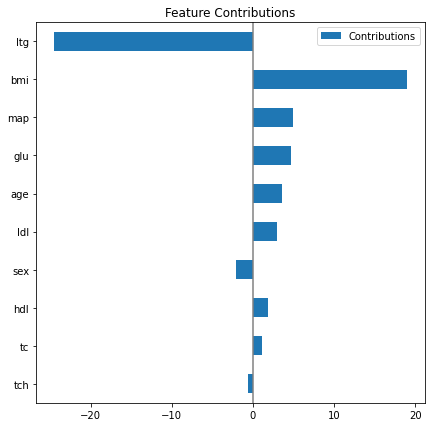

In [2]:
# EnsembleTreeExplainer Example

# loading the diabetes dataset
columns = 'age sex bmi map tc ldl hdl tch ltg glu'.split()
diabetes = load_diabetes()
X = np.array(pd.DataFrame(diabetes.data, columns=columns))
y = diabetes.target

# train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# model training
rf_model = RandomForestRegressor().fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# regression evaluation: r2 score
r2_eval = r2(y_test, y_pred)
print(r2_eval)

# prediction explanation generation
expl = EnsembleTreeExplainer(rf_model)
contributions, contrib_intercept = expl.predict(X_test)
assert(((np.sum(contributions, axis=1) + contrib_intercept) - y_pred < .01).all())

average_contribs = list(zip(columns, np.mean(contributions, axis=0)))
print(average_contribs)

# Plotting mean feature contributions over the total population
plot_contrib_df = pd.DataFrame(np.mean(contributions, axis=0), index=columns, columns=['Contributions'])
final_plot_contrib_df = plot_contrib_df.iloc[plot_contrib_df['Contributions'].abs().argsort()]
final_plot_contrib_df.plot(kind='barh', figsize=(9, 7))
plt.title('Feature Contributions')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)
plt.show()

In [3]:
# XGBOOST EnsembleTreeExplainer Example

# model training
xgb_model = XGBRegressor().fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

# regression evaluation: r2 score
r2_eval = r2(y_test, y_pred)
print(r2_eval)

# prediction explanation generation
expl = EnsembleTreeExplainer(xgb_model)
contributions, contrib_intercept = expl.predict(X_test)
assert(((np.sum(contributions, axis=1) + contrib_intercept) - y_pred < .01).all())

average_contribs = zip(columns, np.mean(contributions, axis=0))
print(list(average_contribs))

0.029332293871153103
[('age', 6.3746495), ('sex', -6.479432), ('bmi', 9.912805), ('map', -0.06479608), ('tc', -1.7230865), ('ldl', 6.853591), ('hdl', 3.9257839), ('tch', 0.38253015), ('ltg', -25.772186), ('glu', 4.4377766)]


0.303056504975194


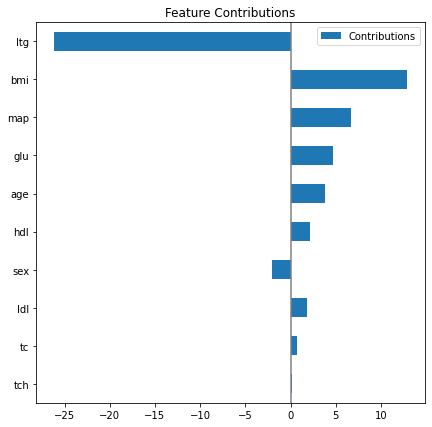

In [5]:
# Explanation Using the Ensemble Tree Explanation Transformer

# model training
rf_model = RandomForestRegressor().fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# regression evaluation: r2 score
r2_eval = r2(y_test, y_pred)
print(r2_eval)

X_test2 = pd.DataFrame(X_test)

expl = EnsembleTreeExplainerTransformer(rf_model)
X_test2 = expl.transform(X_test2)

assert('feature_contributions' in X_test2.columns)
assert('intercept_contribution' in X_test2.columns)
assert((np.abs(np.array(X_test2['feature_contributions'].apply(lambda x: sum(x[0])) + \
                        X_test2['intercept_contribution']) - X_test2['prediction']) < .01).all())

# Plotting mean feature contributions over the total population
plot_contrib_df = pd.DataFrame(np.mean(X_test2['feature_contributions'].apply(lambda x: x[0]), axis=0),
                               index=columns, columns=['Contributions'])

final_plot_contrib_df = plot_contrib_df.iloc[plot_contrib_df['Contributions'].abs().argsort()]
final_plot_contrib_df.plot(kind='barh', figsize=(9, 7))
plt.title('Feature Contributions')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)
plt.show()
